In [1]:
import os
import numpy as np # for using np arrays
import urllib.request
import tarfile

# for reading and processing images
from PIL import Image


# Function to download and extract the dataset
def download_and_extract(url, download_dir, filename, extract_dir):
    # Download the file
    urllib.request.urlretrieve(url, os.path.join(download_dir, filename))

    # Extract the tar.gz file
    with tarfile.open(os.path.join(download_dir, filename), "r:gz") as tar:
        tar.extractall(extract_dir)


# Helper Functions for Data Processing
# Load Data
# the masked images are stored as png, unmasked (original) as jpg
# the names of these 2 are same so for getting the right sample we can just sort the 2 lists
def LoadData(path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)

    # Filter out hidden files (those starting with a period)
    image_dataset = [file for file in image_dataset if not file.startswith('.')]
    image_dataset = [file for file in image_dataset if not file.endswith('.mat')]

    mask_dataset = os.listdir(path2)

    # Filter out hidden files in the annotations folder as well
    mask_dataset = [file for file in mask_dataset if not file.startswith('.')]
    mask_dataset = [file for file in mask_dataset if not file.endswith('.mat')]

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []

    for file in image_dataset:
        orig_img.append(file)

    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in the same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img



# Pre-Process Data
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    total_images = len(img)
    count=0

    # Resize images and masks
    for file in img:
        print(f"\rProcessing image {count + 1} out of {total_images} images", end='', flush=True)
        count = count + 1
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/256.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask
    print()
    return X, y

In [2]:
# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras.metrics import MeanIoU

import tensorflow as tf
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, n_classes=3):
    smooth = 0.001

    # Step 1: Convert prediction to softmax probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Step 2: Convert target to one-hot format
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)

    # Flatten both prediction and target tensors
    y_pred = tf.cast(tf.reshape(y_pred, [-1, n_classes]), tf.float32)
    y_true = tf.cast(tf.reshape(y_true, [-1, n_classes]), tf.float32)

    # Step 4: Calculate intersection and union
    intersection = 2 * tf.reduce_sum(y_true * y_pred, axis=0)
    union = tf.reduce_sum(y_true, axis=0) + tf.reduce_sum(y_pred, axis=0)

    # Step 5: Compute Dice coefficient for each class
    dice = (intersection + smooth) / (union + smooth)

    # Step 6: Return 1 minus the mean Dice coefficient
    return 1 - K.mean(dice)

def binary_cross_entropy_loss(y_true, y_pred, n_classes=3):
    # Step 1: Convert prediction to softmax probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Step 2: Convert target to one-hot format
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)

    # Flatten both prediction and target tensors
    y_pred = tf.cast(tf.reshape(y_pred, [-1, n_classes]), tf.float32)
    y_true = tf.cast(tf.reshape(y_true, [-1, n_classes]), tf.float32)

    # Compute binary cross-entropy loss
    loss = categorical_crossentropy  (y_true, y_pred)
    return loss


# def dice_loss(y_true, y_pred):
#   y_true = tf.cast(y_true, tf.float32)
#   y_pred = tf.cast(y_pred, tf.float32)
#   numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
#   denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
#   return 1 - ((numerator + tf.keras.backend.epsilon()) / (denominator + tf.keras.backend.epsilon()))

# Constructing the U-Net Architecture
# U-Net Encoder Block
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, use_max_pooling=True, use_strided_conv=False, use_upsampling=False):
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    conv = BatchNormalization()(conv, training=False)

    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if use_max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    elif use_strided_conv:
        next_layer = Conv2D(n_filters,
                            3,   # Kernel size
                            activation='relu',
                            padding='same',
                            strides=2)(conv)
    elif use_upsampling:
        next_layer = UpSampling2D()(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

# U-Net Decoder Block
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32, use_transpose_conv=True, use_upsampling=False):
    if use_transpose_conv:
        up = Conv2DTranspose(
            n_filters,
            (3, 3),    # Kernel size
            strides=2,
            activation='relu',
            padding='same')(prev_layer_input)
    elif use_upsampling:
        up = UpSampling2D()(prev_layer_input)
        up = Conv2D(n_filters,
                    3,   # Kernel size
                    activation='relu',
                    padding='same')(up)
    else:
        up = prev_layer_input

    # Ensure the dimensions match by cropping or padding the skip_layer_input
    target_shape = up.shape[1:3]  # Target spatial dimensions
    skip_layer_input = tf.image.resize(skip_layer_input, target_shape, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    merge = concatenate([up, skip_layer_input], axis=3)

    conv = Conv2D(n_filters,
                  3,     # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    return conv



# Compile U-Net Blocks
# Combine both encoder and decoder blocks according to the U-Net research paper
# Return the model as output
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3, use_max_pooling=True, use_transpose_conv=True, use_strided_conv=False, use_upsampling=False, use_dice_loss=False, use_bce=False):
    inputs = Input(input_size)

    cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, use_max_pooling=use_max_pooling, use_strided_conv=use_strided_conv, use_upsampling=use_upsampling)
    cblock2 = EncoderMiniBlock(cblock1[0], n_filters*2, dropout_prob=0, use_max_pooling=use_max_pooling, use_strided_conv=use_strided_conv, use_upsampling=use_upsampling)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4, dropout_prob=0, use_max_pooling=use_max_pooling, use_strided_conv=use_strided_conv, use_upsampling=use_upsampling)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8, dropout_prob=0.3, use_max_pooling=use_max_pooling, use_strided_conv=use_strided_conv, use_upsampling=use_upsampling)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, use_max_pooling=False, use_strided_conv=False, use_upsampling=False)

    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8, use_transpose_conv=use_transpose_conv, use_upsampling=use_upsampling)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4, use_transpose_conv=use_transpose_conv, use_upsampling=use_upsampling)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2, use_transpose_conv=use_transpose_conv, use_upsampling=use_upsampling)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters, use_transpose_conv=use_transpose_conv, use_upsampling=use_upsampling)

    conv9 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    if use_dice_loss:
        loss = dice_loss
    elif use_bce:
        loss = binary_cross_entropy_loss


    print("Model Summary:")
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=['accuracy'])
    return model

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

def unet_train(unet, X, y):
    # Split Train and Test Set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)
    # Run the model in a mini-batch fashion and compute the progress for each epoch
    results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))
    return results, unet, X_train, X_valid, y_train, y_valid


In [4]:
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# View an example of image and corresponding mask
def show_sample_images(path1, path2, img, mask, show_images = 1):
    for i in range(show_images):
        img_view  = imageio.imread(path1 + img[i])
        mask_view = imageio.imread(path2 + mask[i])
        print(img_view.shape)
        print(mask_view.shape)
        fig, arr = plt.subplots(1, 2, figsize=(15, 15))
        arr[0].imshow(img_view)
        arr[0].set_title('Image '+ str(i))
        arr[1].imshow(mask_view)
        arr[1].set_title('Masked Image '+ str(i))


# Visualize the processed output
def show_processed_image(X, y, image_index = 0):
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(X[image_index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y[image_index,:,:,0])
    arr[1].set_title('Processed Masked Image ')


# Bias Variance Check
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plot the graphs for accuracy
def model_metrics(results):
    fig, axis = plt.subplots(1, 2, figsize=(20, 5))
    axis[0].plot(results.history["loss"], color='r', label = 'train loss')
    axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
    axis[0].set_title('Loss Comparison')
    axis[0].legend()
    axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
    axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
    axis[1].set_title('Accuracy Comparison')
    axis[1].legend()

# Results of Validation Dataset
def VisualizeResults(X_valid, unet, y_valid, index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

(400, 600, 3)
(400, 600)
Processing image 16 out of 7390 images

<ipython-input-4-2c5d3367214b>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i])
<ipython-input-4-2c5d3367214b>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 + mask[i])


Processing image 7390 out of 7390 images
X Shape: (7390, 128, 128, 3)
Y shape: (7390, 128, 128, 1)
Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_1[

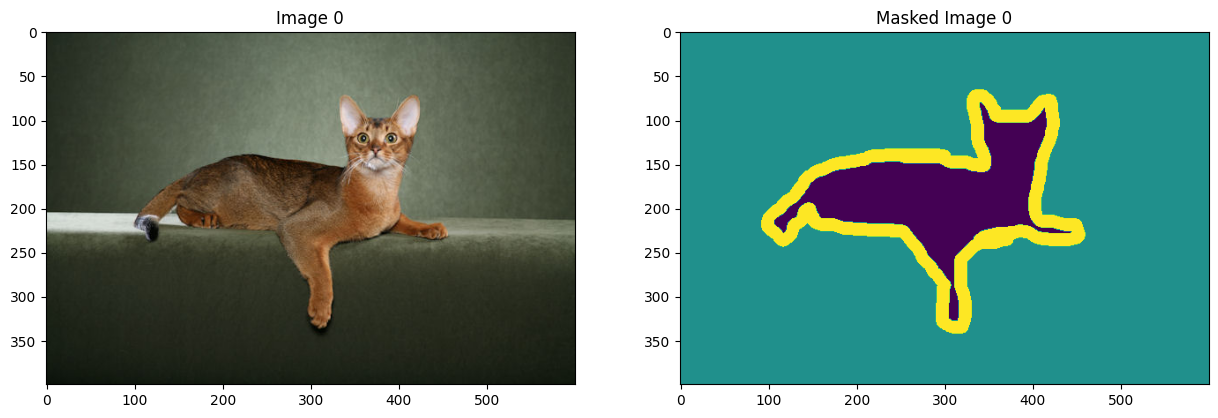

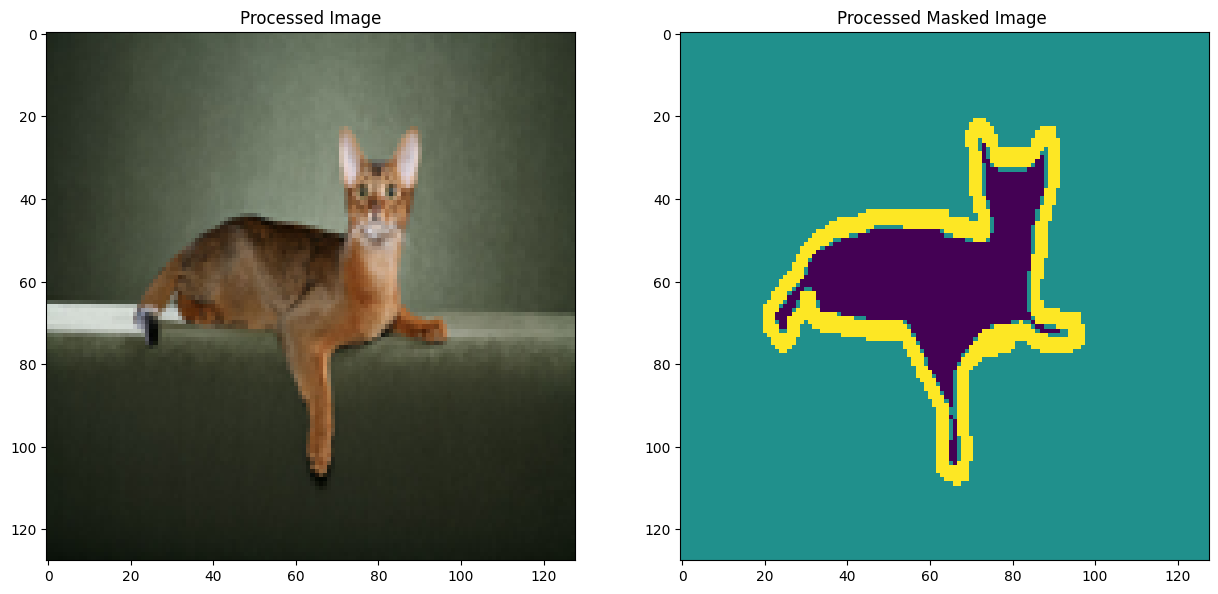

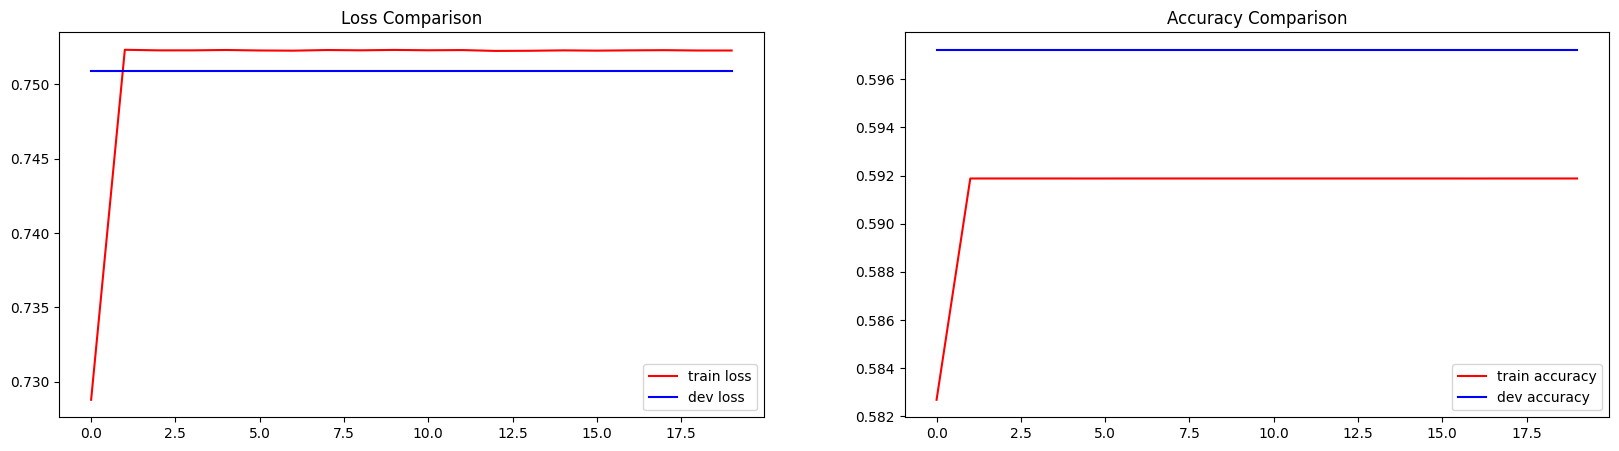

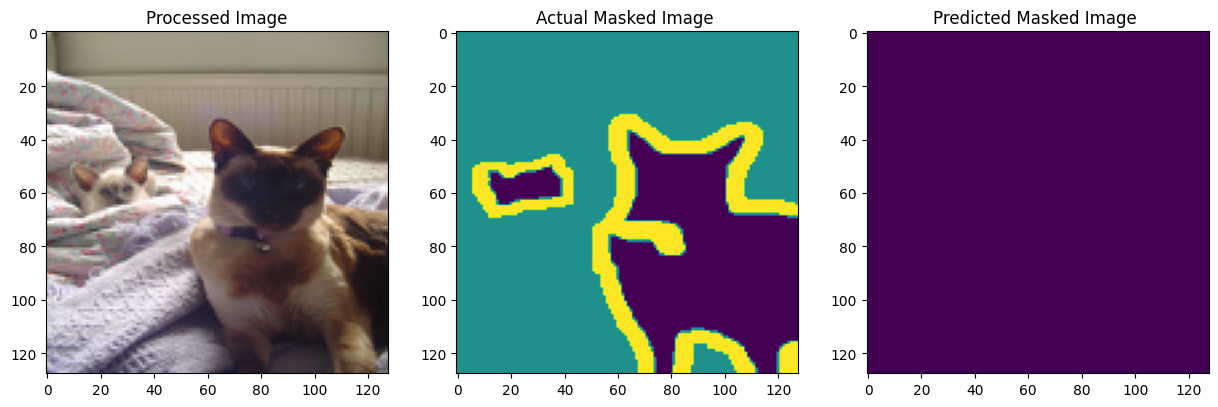

In [5]:
from ast import main
import numpy as np # for using np arrays


if __name__ == "__main__":

    # Define the URL and file names
    dataset_url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    annotations_url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
    dataset_filename = "images.tar.gz"
    annotations_filename = "annotations.tar.gz"

    # Define the download and extraction directory
    download_dir = "/content/"
    extracted_dir = "/content/"
    # Download and extract the dataset and annotations
    download_and_extract(dataset_url, download_dir, dataset_filename, extracted_dir)
    download_and_extract(annotations_url, download_dir, annotations_filename, extracted_dir)

    # Define the paths to the images and masks directories
    images_dir = os.path.join(extracted_dir, "images/")
    masks_dir = os.path.join(extracted_dir, "annotations/trimaps/")


    # Load and View Data
    """ Load Train Set and view some examples """
    # Call the apt function
    path1 = images_dir
    path2 = masks_dir
    img, mask = LoadData (path1, path2)

    show_sample_images(path1, path2, img, mask, show_images = 1)

    # Process Data
    # Define the desired shape
    target_shape_img = [128, 128, 3]
    target_shape_mask = [128, 128, 1]

    # Process data using apt helper function
    X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

    # QC the shape of output and classes in output dataset
    print("X Shape:", X.shape)
    print("Y shape:", y.shape)
    # There are 3 classes : background, pet, outline

    show_processed_image(X, y, image_index = 0)

    unet = UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3, use_max_pooling=False,
                        use_transpose_conv=False, use_strided_conv=True, use_upsampling=True, use_dice_loss=True, use_bce=False)

    # Train the model
    results, unet, X_train, X_valid, y_train, y_valid = unet_train(unet, X, y)

    # Evaluate Model Results
    model_metrics(results)

    # RESULTS
    # The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
    # The accuracy of train and validation is ~90% which is high enough, so low bias
    # and the %s aren't that far apart, hence low variance

    # View Predicted Segmentations
    unet.evaluate(X_valid, y_valid)

    # Add any index to contrast the predicted mask with actual mask
    index = 700
    VisualizeResults(X_valid, unet, y_valid, index)